In [1]:
import numpy as onp
import scipy.io
from scipy.interpolate import griddata

import jax.numpy as np 
from jax import random, grad, vmap, jit
from jax.experimental import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu

from jax.config import config
from jax.flatten_util import ravel_pytree
from jax import lax

import itertools
from functools import partial
from torch.utils import data
from tqdm import trange
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

/scratch/sifanw/anaconda3/lib/python3.8/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Architectures

In [2]:
# Define the neural net
def MLP(layers, activation=relu):
  ''' Vanilla MLP'''
  def init(rng_key):
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
          W = glorot_stddev * random.normal(k1, (d_in, d_out))
          b = np.zeros(d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return params
  def apply(params, inputs):
      for W, b in params[:-1]:
          outputs = np.dot(inputs, W) + b
          inputs = activation(outputs)
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply

# Define the neural net
def modified_MLP(layers, activation=relu):
  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b

  def init(rng_key):
      U1, b1 =  xavier_init(random.PRNGKey(12345), layers[0], layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), layers[0], layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key, *keys = random.split(rng_key, len(layers))
      params = list(map(init_layer, keys, layers[:-1], layers[1:]))
      return (params, U1, b1, U2, b2) 

  def apply(params, inputs):
      params, U1, b1, U2, b2 = params
      U = activation(np.dot(inputs, U1) + b1)
      V = activation(np.dot(inputs, U2) + b2)
      for W, b in params[:-1]:
          outputs = activation(np.dot(inputs, W))
          inputs = np.multiply(outputs, U) + np.multiply(1 - outputs, V) 
      W, b = params[-1]
      outputs = np.dot(inputs, W) + b
      return outputs
  return init, apply


def modified_deeponet(branch_layers, trunk_layers, activation=relu):

  def xavier_init(key, d_in, d_out):
      glorot_stddev = 1. / np.sqrt((d_in + d_out) / 2.)
      W = glorot_stddev * random.normal(key, (d_in, d_out))
      b = np.zeros(d_out)
      return W, b
  
  def init(rng_key1, rng_key2):
      U1, b1 =  xavier_init(random.PRNGKey(12345), branch_layers[0], branch_layers[1])
      U2, b2 =  xavier_init(random.PRNGKey(54321), trunk_layers[0], trunk_layers[1])
      def init_layer(key, d_in, d_out):
          k1, k2 = random.split(key)
          W, b = xavier_init(k1, d_in, d_out)
          return W, b
      key1, *keys1 = random.split(rng_key1, len(branch_layers))
      key2, *keys2 = random.split(rng_key2, len(trunk_layers))
      branch_params = list(map(init_layer, keys1, branch_layers[:-1], branch_layers[1:]))
      trunk_params = list(map(init_layer, keys2, trunk_layers[:-1], trunk_layers[1:]))
      return (branch_params, trunk_params, U1, b1, U2, b2)

  def apply(params, u, y):
      branch_params, trunk_params, U1, b1, U2, b2 = params
      U = activation(np.dot(u, U1) + b1)
      V = activation(np.dot(y, U2) + b2)
      for k in range(len(branch_layers)-2):
          W_b, b_b =  branch_params[k]
          W_t, b_t =  trunk_params[k]

          B = activation(np.dot(u, W_b) + b_b)
          T = activation(np.dot(y, W_t) + b_t)

          u = np.multiply(B, U) + np.multiply(1 - B, V) 
          y = np.multiply(T, U) + np.multiply(1 - T, V) 

      W_b, b_b =  branch_params[-1]
      W_t, b_t =  trunk_params[-1]
      B = np.dot(u, W_b) + b_b
      T = np.dot(y, W_t) + b_t
      outputs = np.sum(B * T)
      return outputs

  return init, apply

 # Data Sampler 

In [3]:
class DataGenerator(data.Dataset):
    def __init__(self, u, y, s, 
                 batch_size=64, rng_key=random.PRNGKey(1234)):
        'Initialization'
        self.u = u
        self.y = y
        self.s = s
        
        self.N = u.shape[0]
        self.batch_size = batch_size
        self.key = rng_key

    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        return inputs, outputs

    @partial(jit, static_argnums=(0,))
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        idx = random.choice(key, self.N, (self.batch_size,), replace=False)
        s = self.s[idx,:]
        y = self.y[idx,:]
        u = self.u[idx,:]
        # Construct batch
        inputs = (u, y)
        outputs = s
        return inputs, outputs

In [4]:
# Define the model
class PI_DeepONet:
    def __init__(self, arch, weights, branch_layers, trunk_layers):  
        self.arch = arch
        self.weights = weights  

        # Network initialization and evaluation functions
        if self.arch =='MLP':
            self.branch_init, self.branch_apply = MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_MLP':
            self.branch_init, self.branch_apply = modified_MLP(branch_layers, activation=np.tanh)
            self.trunk_init, self.trunk_apply = modified_MLP(trunk_layers, activation=np.tanh)

            branch_params = self.branch_init(rng_key = random.PRNGKey(1234))
            trunk_params = self.trunk_init(rng_key = random.PRNGKey(4321))
            params = (branch_params, trunk_params)
        
        if self.arch =='modified_deeponet':
            self.init, self.apply = modified_deeponet(branch_layers, trunk_layers, activation=np.tanh)
            params = self.init(rng_key1 = random.PRNGKey(1234), rng_key2 = random.PRNGKey(4321))

        # Use optimizers to set optimizer initialization and update functions
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(optimizers.exponential_decay(1e-3, 
                                                                      decay_steps=5000, 
                                                                      decay_rate=0.9))
        self.opt_state = self.opt_init(params)

        _, self.unravel_params = ravel_pytree(params)

        # Logger
        self.itercount = itertools.count()
        self.current_count = 0

        self.loss_log = []
        self.loss_ics_log = []
        self.loss_s_bc_log = []
        self.loss_s_x_bc_log = []
        self.loss_res_log = []

    # Define the opeartor net
    def operator_net(self, params, u, t, x):
        if self.arch == 'modified_deeponet':
            y = np.stack([t,x])
            outputs = self.apply(params, u, y)
        else:
            y = np.stack([t,x])
            branch_params, trunk_params = params
            B = self.branch_apply(branch_params, u)
            T = self.trunk_apply(trunk_params, y)
            outputs = np.sum(B * T)
        return  outputs
    
    def s_x_net(self, params, u, t, x):
         s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
         return s_x
            
    def residual_net(self, params, u, t, x):
        s = self.operator_net(params, u, t, x)
        s_t = grad(self.operator_net, argnums=2)(params, u, t, x)
        s_x = grad(self.operator_net, argnums=3)(params, u, t, x)
        s_xx= grad(grad(self.operator_net, argnums=3), argnums=3)(params, u, t, x)

        res = s_t + s * s_x - nu_val * s_xx
        return res

    def compute_K_ic(self, params, u, t, x):
        
        K_ic = grad(self.operator_net, argnums=0)(params, u, t, x)
        K_ic, _ = ravel_pytree(K_ic)
        K_ic = np.dot(K_ic, K_ic)

        return K_ic

    def compute_K_bc(self, params, u, t, x1, x2):
        def s_bc_pred(params, u, t, x1, x2):
            output = self.operator_net(params, u, t, x1) - self.operator_net(params, u, t, x2)
            return output
        
        def s_x_bc_pred(params, u, t, x1, x2):
            output = self.s_x_net(params, u, t, x1) - self.s_x_net(params, u, t, x2)
            return output

        K_bc = grad(s_bc_pred, argnums=0)(params, u, t, x1, x2)
        K_x_bc = grad(s_x_bc_pred, argnums=0)(params, u, t, x1, x2)

        K_bc, _ = ravel_pytree(K_bc)
        K_x_bc, _ = ravel_pytree(K_x_bc)

        K_bc = np.dot(K_bc, K_bc)
        K_x_bc = np.dot(K_x_bc, K_x_bc)

        return K_bc, K_x_bc
    
    def compute_K_r(self, params, u, t, x):
        def r_pred(params, u, t, x):
            output = self.residual_net(params, u, t, x)
            return output
        
        K_r = grad(r_pred, argnums=0)(params, u, t, x)
        K_r, _ = ravel_pytree(K_r)
        K_r = np.dot(K_r, K_r)

        return K_r
    

    @partial(jit, static_argnums=(0,))
    def loss_ics(self, params, batch):
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        # Compute loss
        loss = np.mean((outputs.flatten() - s_pred.flatten())**2)
        return loss

    @partial(jit, static_argnums=(0,))
    def loss_bcs(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])

        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u, y[:,2], y[:,3])
        
        # Compute loss
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2)

        return loss_s_bc, loss_s_x_bc

    @partial(jit, static_argnums=(0,))
    def loss_res(self, params, batch):
        # Fetch data
        inputs, outputs = batch
        u, y = inputs
        # Compute forward pass
        pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u, y[:,0], y[:,1])

        # Compute loss
        loss = np.mean((pred)**2)
        return loss

  
    @partial(jit, static_argnums=(0,))
    def loss(self, params, ics_batch, bcs_batch, res_batch):

        ics_inputs, ics_outputs = ics_batch
        bcs_inputs, bcs_outputs = bcs_batch
        res_inputs, res_outputs = res_batch

        u_ics, y_ics = ics_inputs
        u_bcs, y_bcs = bcs_inputs
        u_res, y_res = res_inputs

        # Compute forward pass
        s_ic_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u_ics, y_ics[:,0], y_ics[:,1])

        s_bc1_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,0], y_bcs[:,1])
        s_bc2_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,2], y_bcs[:,3])
        s_x_bc1_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,0], y_bcs[:,1])
        s_x_bc2_pred = vmap(self.s_x_net, (None, 0, 0, 0))(params, u_bcs, y_bcs[:,2], y_bcs[:,3])

        s_r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, u_res, y_res[:,0], y_res[:,1])

        # Compute weights
        if self.weights=='no_weights':
            lam_ic = 1
            lam_bc = 1
            lam_bc_x = 1
            lam_r = 1
        
        elif self.weights == 'fixed_weights':
            lam_ic = 10
            lam_bc = 10
            lam_bc_x = 10
            lam_r = 1

        else:
            # Compute weights
            K_ic = vmap(self.compute_K_ic, (None, 0, 0, 0))(params, u_ics, y_ics[:,0], y_ics[:,1])
            K_bc, K_x_bc = vmap(self.compute_K_bc, (None, 0, 0, 0, 0))(params, u_bcs, y_bcs[:,0], y_bcs[:,1], y_bcs[:,3])
            K_r = vmap(self.compute_K_r, (None, 0, 0, 0))(params, u_res, y_res[:,0], y_res[:,1])
            K = np.stack([K_ic, K_bc, K_x_bc, K_r])

            if self.weights == 'global_NTK_weights':
                K_sum = np.sum(K)

                lam_ic = lax.stop_gradient(K_sum / np.sum(K_ic))
                lam_bc = lax.stop_gradient(K_sum / np.sum(K_bc))
                lam_bc_x = lax.stop_gradient(K_sum / np.sum(K_x_bc))
                lam_r = lax.stop_gradient(K_sum / np.sum(K_r))

            elif self.weights=='local_NTK_weights':

                K_max = K.max()

                lam_ic = lax.stop_gradient(K_max / K_ic)
                lam_bc = lax.stop_gradient(K_max / K_bc)
                lam_bc_x = lax.stop_gradient(K_max / K_x_bc)
                lam_r = lax.stop_gradient(K_max / K_r)

            elif self.weights=='moderate_local_NTK_weights':

                K_max = K.max()

                lam_ic = lax.stop_gradient(np.sqrt(K_max / K_ic))
                lam_bc = lax.stop_gradient(np.sqrt(K_max / K_bc))
                lam_bc_x = lax.stop_gradient(np.sqrt(K_max / K_x_bc))
                lam_r = lax.stop_gradient(np.sqrt(K_max / K_r))

        # Compute loss
        loss_ic = np.mean((s_ic_pred.flatten() - ics_outputs.flatten())**2 * lam_ic)
        loss_s_bc = np.mean((s_bc1_pred - s_bc2_pred)**2 * lam_bc)
        loss_s_x_bc = np.mean((s_x_bc1_pred - s_x_bc2_pred)**2 * lam_bc_x)
        loss_res = np.mean((s_r_pred)**2 * lam_r)
        
        loss = loss_ic + loss_s_bc + loss_s_x_bc + loss_res
        return loss

    # Define a compiled update step
    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, ics_batch, bcs_batch, res_batch):
        params = self.get_params(opt_state)
        g = grad(self.loss)(params, ics_batch, bcs_batch, res_batch)
        return self.opt_update(i, g, opt_state)

    # Optimize parameters in a loop
    def train(self, ics_dataset, bcs_dataset, res_dataset, nIter = 10000):
        ics_data = iter(ics_dataset)
        bcs_data = iter(bcs_dataset)
        res_data = iter(res_dataset)

        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            ics_batch= next(ics_data)
            bcs_batch= next(bcs_data)
            res_batch = next(res_data)

            self.current_count =  next(self.itercount)
            self.opt_state = self.step(self.current_count, self.opt_state, ics_batch, bcs_batch, res_batch)
            
            if it % 1000 == 0:
                params = self.get_params(self.opt_state)

                loss_value = self.loss(params, ics_batch, bcs_batch, res_batch)
                loss_ics_value = self.loss_ics(params, ics_batch)
                loss_s_bc_value, loss_s_x_bc_value = self.loss_bcs(params, bcs_batch)
                loss_res_value = self.loss_res(params, res_batch)

                self.loss_log.append(loss_value)
                self.loss_ics_log.append(loss_ics_value)
                self.loss_s_bc_log.append(loss_s_bc_value)
                self.loss_s_x_bc_log.append(loss_s_x_bc_value)
                self.loss_res_log.append(loss_res_value)

                pbar.set_postfix({'Loss': loss_value, 
                                  'loss_ics' : loss_ics_value,
                                  'loss_s_bc' : loss_s_bc_value, 
                                  'loss_s_x_bc' : loss_s_x_bc_value, 
                                  'loss_physics': loss_res_value})
       
           
    # Evaluates predictions at test points  
    @partial(jit, static_argnums=(0,))
    def predict_s(self, params, U_star, Y_star):
        s_pred = vmap(self.operator_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return s_pred

    @partial(jit, static_argnums=(0,))
    def predict_res(self, params, U_star, Y_star):
        r_pred = vmap(self.residual_net, (None, 0, 0, 0))(params, U_star, Y_star[:,0], Y_star[:,1])
        return r_pred

# Data Generation

In [5]:
 def generate_one_ics_training_data(key, u0, m=101, P=101):

    t_0 = np.zeros((P,1))
    x_0 = np.linspace(0, 1, P)[:, None]

    y = np.hstack([t_0, x_0])
    u = np.tile(u0, (P, 1))
    s = u0

    return u, y, s

def generate_one_bcs_training_data(key, u0, m=101, P=100):

    t_bc = random.uniform(key, (P,1))
    x_bc1 = np.zeros((P, 1))
    x_bc2 = np.ones((P, 1))
  
    y1 = np.hstack([t_bc, x_bc1])  # shape = (P, 2)
    y2 = np.hstack([t_bc, x_bc2])  # shape = (P, 2)

    u = np.tile(u0, (P, 1))
    y =  np.hstack([y1, y2])  # shape = (P, 4)
    s = np.zeros((P, 1))

    return u, y, s

def generate_one_res_training_data(key, u0, m=101, P=1000):

    subkeys = random.split(key, 2)
   
    t_res = random.uniform(subkeys[0], (P,1))
    x_res = random.uniform(subkeys[1], (P,1))

    u = np.tile(u0, (P, 1))
    y =  np.hstack([t_res, x_res])
    s = np.zeros((P, 1))

    return u, y, s

def generate_one_test_data(idx,usol, m=101, P=101):

    u = usol[idx]
    u0 = u[0,:]

    t = np.linspace(0, 1, P)
    x = np.linspace(0, 1, P)
    T, X = np.meshgrid(t, x)

    s = u.T.flatten()
    u = np.tile(u0, (P**2, 1))
    y = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])

    return u, y, s 

def compute_error(idx, usol, m, P):
    u_test, y_test, s_test = generate_one_test_data(idx, usol, m, P)

    u_test = u_test.reshape(P**2,-1)  
    y_test = y_test.reshape(P**2,-1)
    s_test = s_test.reshape(P**2,-1)

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    error = np.linalg.norm(s_test - s_pred) / np.linalg.norm(s_test) 

    return error

    

In [6]:
# Load dataset
data = scipy.io.loadmat('burger_nu_0.001.mat')
usol = np.array( data['output'])
nu_val = 1e-3  # Please make sure the viscosity is consisent with the dataset!

In [7]:
# Generate training data
N = usol.shape[0]

N_train = 1000
N_test = 100
m = 101
P_ics_train = 101
P_bcs_train = 100
P_res_train = 2500
P_test = 101

u0_train = usol[:N_train,0,:]
usol_train = usol[:N_train,:,:]

key = random.PRNGKey(0) # use different key for generating training data 
keys = random.split(key, N_train)

# Generate training data for inital condition
u_ics_train, y_ics_train, s_ics_train = vmap(generate_one_ics_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_ics_train)

u_ics_train = u_ics_train.reshape(N_train * P_ics_train,-1)  
y_ics_train = y_ics_train.reshape(N_train * P_ics_train,-1)
s_ics_train = s_ics_train.reshape(N_train * P_ics_train,-1)

# Generate training data for boundary condition
u_bcs_train, y_bcs_train, s_bcs_train = vmap(generate_one_bcs_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_bcs_train)

u_bcs_train = u_bcs_train.reshape(N_train * P_bcs_train,-1)  
y_bcs_train = y_bcs_train.reshape(N_train * P_bcs_train,-1)
s_bcs_train = s_bcs_train.reshape(N_train * P_bcs_train,-1)

# Generate training data for PDE residual
u_res_train, y_res_train, s_res_train = vmap(generate_one_res_training_data, in_axes=(0, 0, None, None))(keys, u0_train, m, P_res_train)

u_res_train = u_res_train.reshape(N_train * P_res_train,-1)  
y_res_train = y_res_train.reshape(N_train * P_res_train,-1)
s_res_train = s_res_train.reshape(N_train * P_res_train,-1)


In [8]:
# Choose one of DeepONet architecture 
arch = 'modified_deeponet'  # ['MLP', 'modified_MLP']
# Choose one of Weight scheme (below)
# ['no_weights', 'fixed_weights', 'global_NTK_weights', 'local_NTK_weights', 'moderate_local_NTK_weights']
weights = 'moderate_local_NTK_weights' 

branch_layers = [m, 100, 100, 100, 100, 100, 100, 100]
trunk_layers =  [2, 100, 100, 100, 100, 100, 100, 100]

# Initialize model
model = PI_DeepONet(arch, weights, branch_layers, trunk_layers)

In [9]:
# Create data set
batch_size = 10000
ics_dataset = DataGenerator(u_ics_train, y_ics_train, s_ics_train, batch_size)
bcs_dataset = DataGenerator(u_bcs_train, y_bcs_train, s_bcs_train, batch_size)
res_dataset = DataGenerator(u_res_train, y_res_train, s_res_train, batch_size)

In [10]:
# # Train
nIter = 200000
model.train(ics_dataset, bcs_dataset, res_dataset, nIter=nIter)

In [11]:
# Save the trained model and losses
# flat_params, _  = ravel_pytree(model.get_params(model.opt_state))
# np.save('Burger_params.npy', flat_params)
# np.save('Burger_losses.npy', np.array([model.loss_res_log, 
#                                        model.loss_ics_log, 
#                                        model.loss_s_bc_log, 
#                                        model.loss_s_x_bc_log]))

# Restore the trained model and losses
params = model.unravel_params(np.load('Burger_params.npy'))
losses = np.load('Burger_losses.npy')

In [12]:
# Predict
# params = model.get_params(model.opt_state)

k= 1600
N_test= 200
idx = np.arange(k, k + N_test)

errors = vmap(compute_error, in_axes=(0, None, None, None))(idx, usol, m, P_test)
mean_error = errors.mean()
std_error =  errors.std()

print('Mean relative L2 error of s: {:.3e}'.format(mean_error))
print('std relative L2 error of s: {:.3e}'.format(std_error))

Mean relative L2 error of s: 3.493e-02
std relative L2 error of s: 3.736e-02


In [13]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({
                      "text.usetex": True,
                      "font.family": "serif",
                      'text.latex.preamble': r'\usepackage{amsmath}',
                      'font.size': 20,
                      'lines.linewidth': 2,
                      'axes.labelsize': 20,  # fontsize for x and y labels (was 10)
                      'axes.titlesize': 22,
                      'xtick.labelsize': 20,
                      'ytick.labelsize': 20,
                      'legend.fontsize': 20,
                      'axes.linewidth': 2})

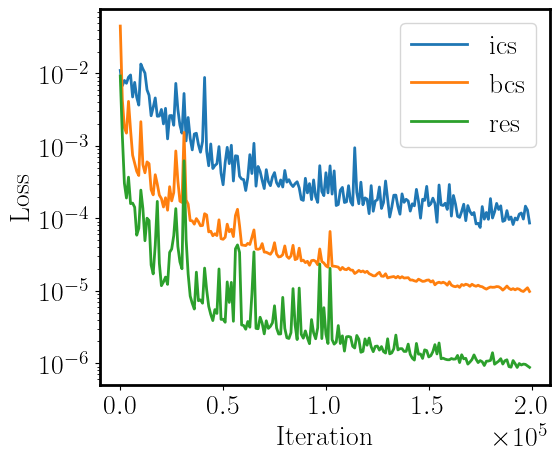

In [14]:
#loss function

iters = 1000 * np.arange(len(losses[0]))

plt.figure(figsize = (6,5))
# plt.plot(model.loss_log, lw=2)
plt.plot(iters, losses[0], lw=2, label='ics')
plt.plot(iters, losses[1], lw=2, label='bcs')
plt.plot(iters, losses[2], lw=2, label='res')

plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))

plt.legend()
plt.tight_layout()
plt.show()


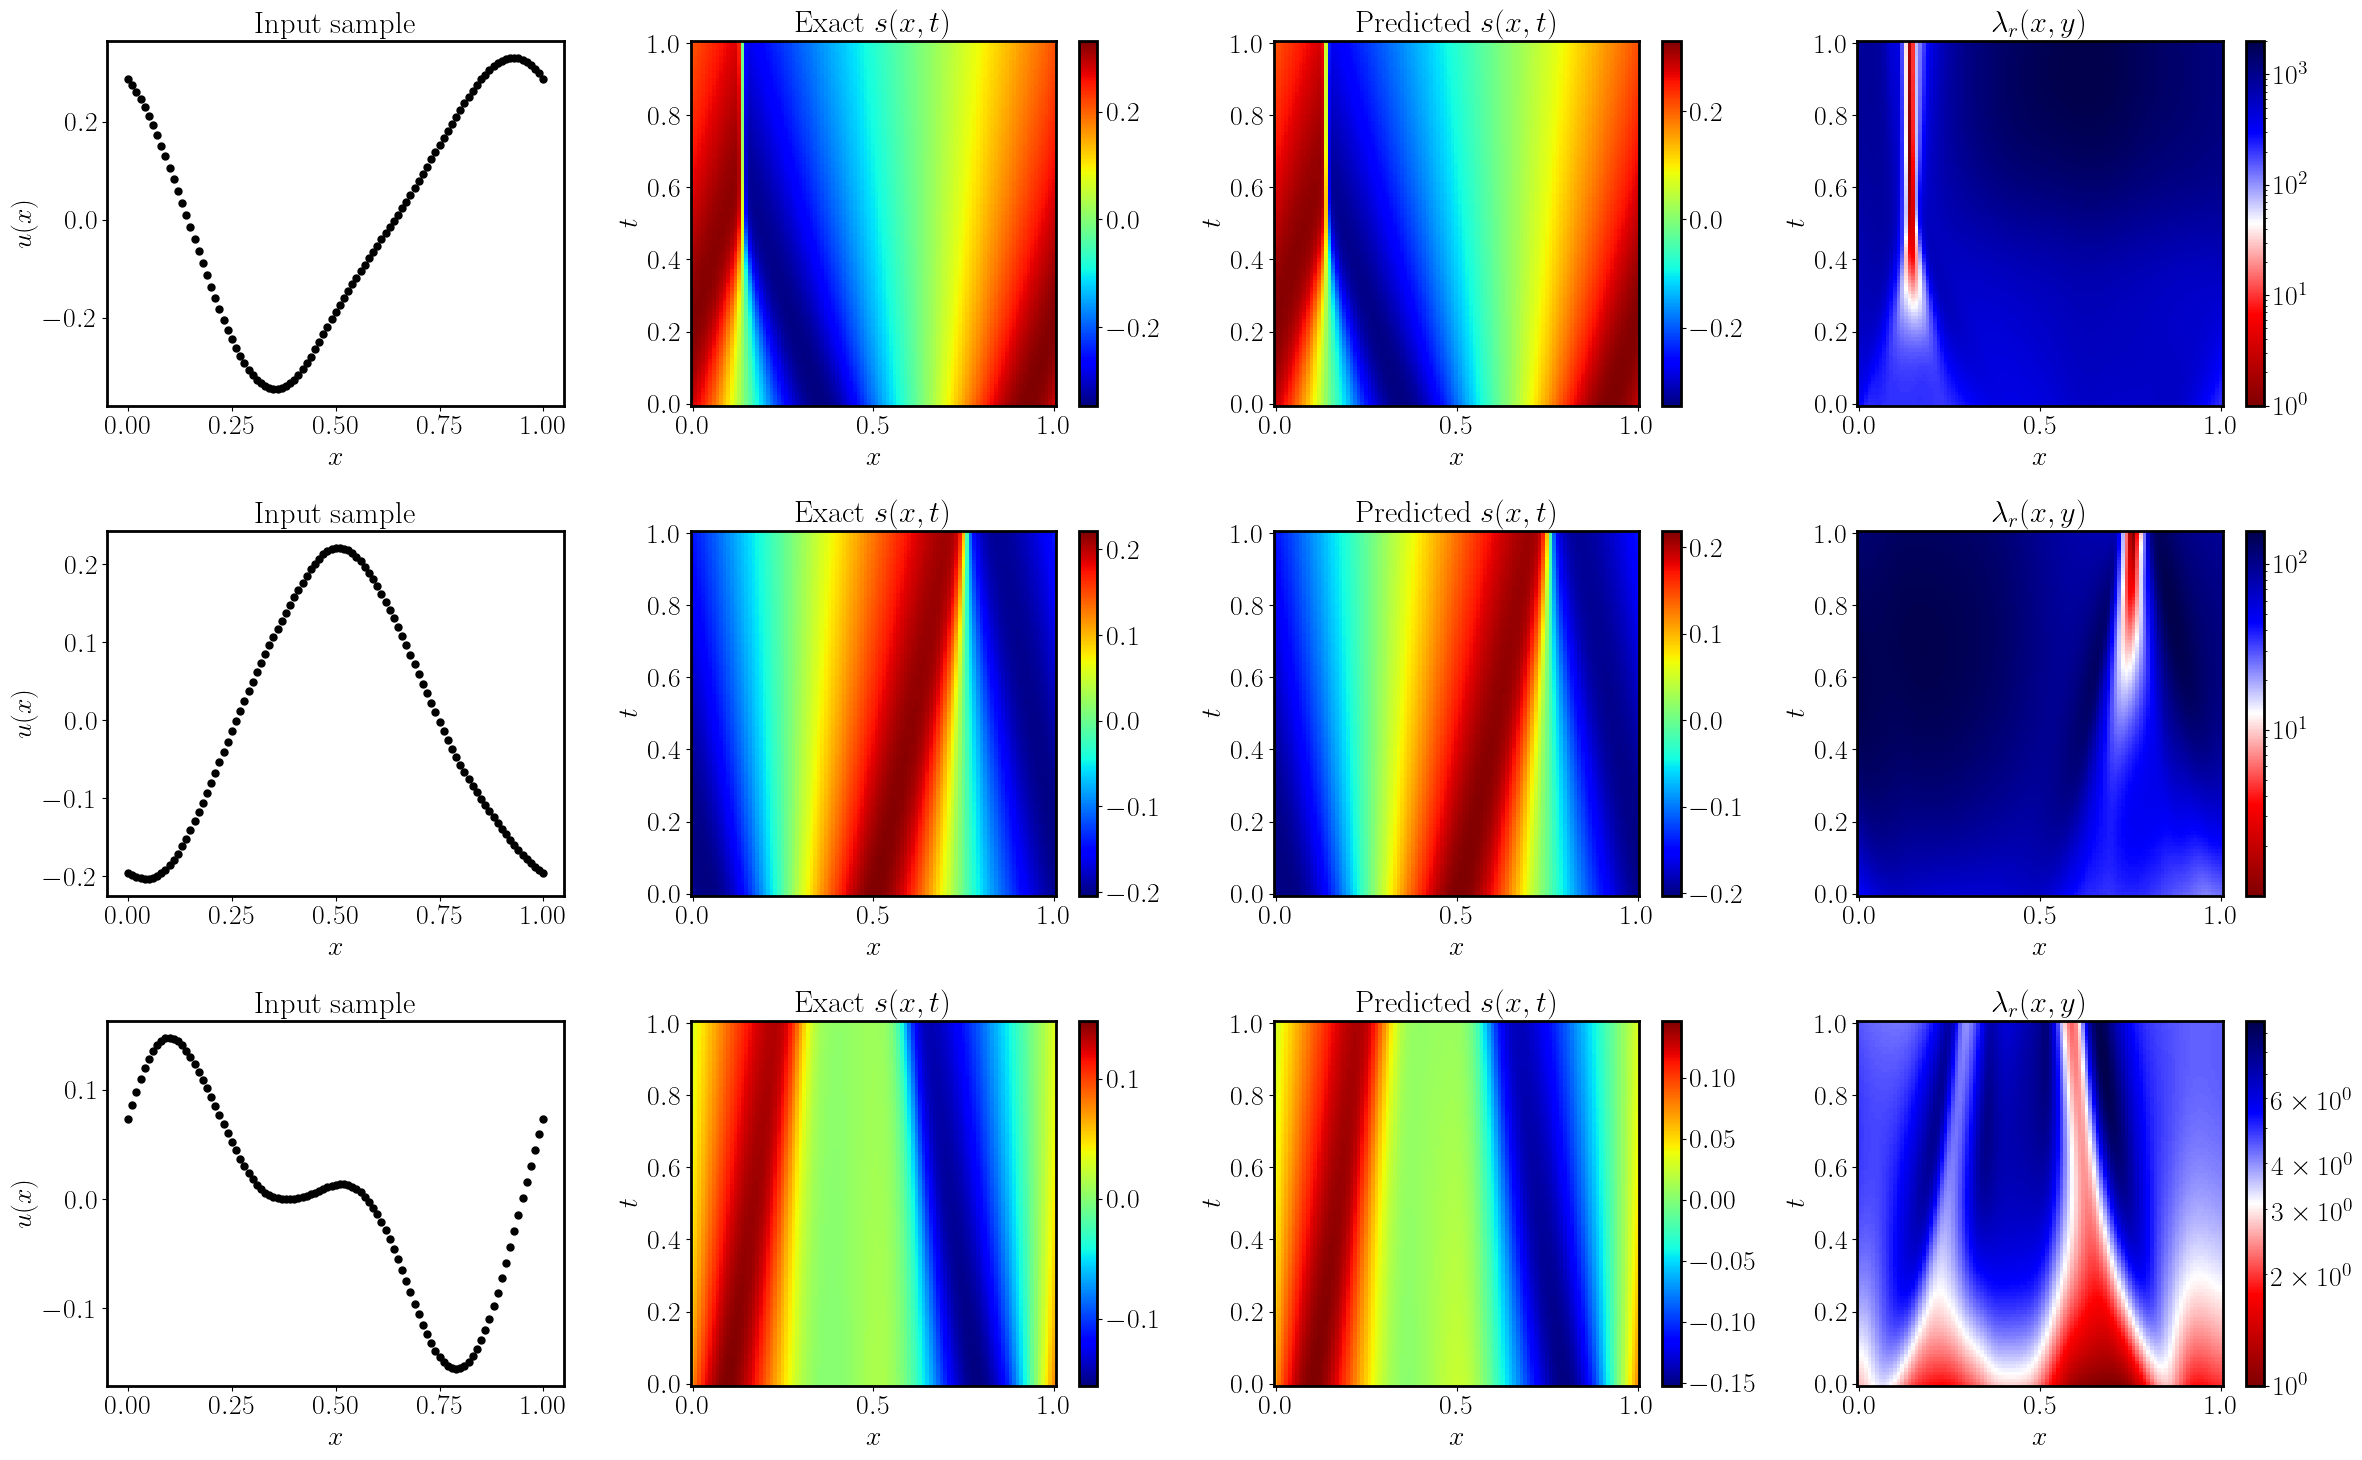

In [15]:
# Test data
P_test = 101
t = np.linspace(0, 1, P_test)
x = np.linspace(0, 1, P_test)
T, X = np.meshgrid(t, x)


idxs = [3, 1619, 1614]

i = 0

fig = plt.figure(figsize = (24, 15))
for k in range(3):

    idx = idxs[k]
    u = usol[idx,:, :]
    u0 = usol[idx,0,:]

    u_test = np.tile(u0, (P_test**2, 1))
    y_test = np.hstack([T.flatten()[:,None], X.flatten()[:,None]])
    s_test = u.flatten()[:,None]

    s_pred = model.predict_s(params, u_test, y_test)[:,None]
    K_r = vmap(model.compute_K_r, (None, 0, 0, 0))(params, u_test, y_test[:,0], y_test[:,1])
    
    S_pred = griddata(y_test, s_pred.flatten(), (T, X), method='cubic')
    K_r = griddata(y_test, K_r.flatten(), (T, X), method='cubic') / K_r.max()

    plt.subplot(3,4, i+1 )
    plt.plot(x, u0, '.', color='black', markersize= 10)
    plt.xlabel('$x$')
    plt.ylabel('$u(x)$')
 
    plt.title('Input sample')
    plt.tight_layout()

    plt.subplot(3,4,i+2)
    plt.pcolor(T, X, u, cmap='jet')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Exact $s(x,t)$')

    plt.colorbar()
    plt.tight_layout()

    plt.subplot(3,4,i+3)
    plt.pcolor(T, X, S_pred.T, cmap='jet')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('Predicted  $s(x,t)$')
    plt.colorbar()
    plt.tight_layout()
    
    plt.subplot(3,4,i+4)
    plt.pcolor(T, X, 1 / K_r.T, norm=colors.LogNorm(vmin=(1 / K_r).min(), vmax= (1 /K_r).max()), cmap='seismic_r')
    plt.xlabel('$x$')
    plt.ylabel('$t$')
    plt.title('$\lambda_r(x,y)$')
    plt.colorbar()
    plt.tight_layout()
    i = i + 4
plt.show()